In [1]:
import numpy
import scipy.sparse
import scipy.linalg
from matplotlib import pyplot as plt
import mpmath

In [2]:
def generate_mesh(x_min, x_max, n_cells):
    """Generates a uniform mesh of n_cells on the interval [x_min, x_max].

    Generates a uniform mesh with n_cells on the interval [x_min, x_max].
    A (1D) mesh is a collection of (n_cells + 1) points (vertices) and a 
    list of n_cells pairs of indices of two vertices defining the cells.

    The k-th mesh vertex, x_k, is given by
        x_k = x_min + k delta_x, k = 0, ..., n

    where
        delta_x = (x_max - x_min)/n_cells 

    The k-th cell of the mesh is
        c_k = [k, k + 1]
        
    meaning that cell k is bounded by vertex k and vertex (k+1).

    Parameters
    ----------
    x_min : float
        The lower bound of the interval over which the mesh will be generated.
    x_max : float
        The upper bound of the interval over which the mesh will be generated.
    n_cells : int
        The number of cells of the mesh.

    Returns
    -------
    vertices: numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells: numpy.array(int), size [2, n]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell
    """

    # Make some quantities more clear
    n_vertices = n_cells + 1

    # Generate the vertices
    vertices = numpy.linspace(x_min, x_max, n_vertices)

    # Generate the cells
    cells = numpy.zeros([n_cells, 2], dtype=numpy.int64)
    cells[:, 0] = numpy.arange(0, n_vertices - 1)  # the index of the lower bound vertex of the cell
    cells[:, 1] = numpy.arange(1, n_vertices)  # the index of the lower bound vertex of the cell

    return vertices, cells

In [3]:
def evaluate_local_basis_1D(xi):
    """Evaluates the two 1D element basis in the local element [0, 1].

    Evaluates the two 1D element basis in the local element [0, 1], at the
    points xi. The points xi must be in the interval [0, 1].

    Since there are two basis the output B_local will be an array such that
        - B_local[0, :] is the evaluation of the first basis over the points xi
        - B_local[1, :] is the evaluation of the second basis over the points xi
         
    The basis are:
        - B_local_0(x): 1 - x
        - B_local_1(x): x
        
    Parameters
    ----------
    xi : numpy.array(float), size [1, n]
        The points in the interval [0, 1] where to evaluate the basis functions.

    Returns
    -------
    B_local : numpy.array(float), size [2, n]
        The two local basis evaluated at the points xi.
    """

    # Allocate memory for the basis
    B_local = numpy.zeros([2, xi.shape[0]])

    # Compute the basis at the xi points
    B_local[0, :] = 1.0 - xi 
    B_local[1, :] = xi

    return B_local


def evaluate_local_basis_1D_d_dx(xi):
    """Evaluates the derivative of the two 1D element basis in the local element [0, 1].

    Evaluates the derivative of the two 1D element basis in the local element [0, 1], at the
    points xi. The points xi must be in the interval [0, 1].

    Since there are two basis the output B_local_d_dx will be an array such that
        - B_local_d_dx[0, :] is the evaluation of the derivative of the first basis over the points xi
        - B_local_d_dx[1, :] is the evaluation of the derivative of the  second basis over the points xi
         
    The basis are:
        - B_local_0(x): 1 - x
        - B_local_1(x): x

    Therefore the derivatives are:
        - B_local_0_d_dx(x): -1.0
        - B_local_1_d_dx(x): 1.0
        
    Parameters
    ----------
    xi : numpy.array(float), size [1, n]
        The points in the interval [0, 1] where to evaluate the basis functions.

    Returns
    -------
    B_local_d_dx : numpy.array(float), size [2, n]
        The derivative of the two local basis evaluated at the points xi.
    """

    # Allocate memory for the basis
    B_local_d_dx = numpy.zeros([2, xi.shape[0]])

    # Compute the basis at the xi points
    B_local_d_dx[0, :] = -numpy.ones_like(xi) 
    B_local_d_dx[1, :] = numpy.ones_like(xi)

    return B_local_d_dx

In [4]:
def evaluate_function(u, vertices, cells, n_points_per_cell = 2):
    """Evaluates a FEM function with coefficients u on a mesh of vertices and cells.

    Based on the coefficients u and the mesh, compute the FEM function:
        u_eval = \sum_{k=0}^{n} u_{i} B_{i}(x)
    
    The evaluation is made per element. This is not the most efficient way to evaluate
    a FEM function for linear basis. You can just use the coefficients.
        
    Parameters
    ----------
    u : numpy.array(float), size [1, n+1]
        The coefficients of the expansion of the function u to evaluate.
    vertices : numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [2, n]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell
    n_points_per_cell : [optional] int, default 2
        The number of points on which to evaluate u in each cell. The default (2)
        is sufficient for linear basis. This is added, for the general case.

    Returns
    -------
    u_eval : numpy.array(float), size [n, n_points_per_cell]
        The evaluation of u at each of the n cells over the n_points_per_cell points inside each cell.
    x_eval : numpy.array(float), size [n, n_points_per_cell]
        The global points where u_eval is evaluated. Needed for plotting.
    """

    # Determine information on the mesh
    n_cells = cells.shape[0]
    delta_x = numpy.diff(vertices[cells]).flatten()

    # Plot the basis B_k (combination of the different parts over the cells)
    xi = numpy.linspace(0, 1, n_points_per_cell)  
    u_eval = numpy.zeros([n_cells, n_points_per_cell])  # allocate the space where to store the basis evaluated at each cell
    x_eval = numpy.zeros([n_cells, n_points_per_cell])  # allocate the space where to store the global coordinates of where the basis are evaluated

    B_local_basis = evaluate_local_basis_1D(xi)  # this is the basis evaluated at the point inside each k-element at the points
                                                        #     xi*(delta_x) + vertices[cells[k, 0]]
                                                        # with delta_x the cell size
    
    for cell_idx, cell in enumerate(cells):
        x_eval[cell_idx, :] = xi * delta_x[cell_idx] + vertices[cell[0]]  # convert the local xi coordinates in the cell into global x coordinates
        u_eval[cell_idx, :] = u[cell] @ B_local_basis  # compute the linear combination of basis based on the coefficients
                                                           # associated to the vertices of the cell
        
    return u_eval, x_eval


def evaluate_function_d_dx(u, vertices, cells, n_points_per_cell = 2):
    """Evaluates the derivative of a FEM function with coefficients u on a mesh of vertices and cells.

    Based on the coefficients u and the mesh, compute the FEM function:
        u_eval = \sum_{k=0}^{n} u_{i} dB_{i}(x)/dx
    
    The evaluation is made per element. This is not the most efficient way to evaluate
    the derivative of a FEM function for linear basis. You can just use the coefficients
    and compute differences.
        
    Parameters
    ----------
    u : numpy.array(float), size [1, n+1]
        The coefficients of the expansion of the function u to evaluate.
    vertices : numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [2, n]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell
    n_points_per_cell : [optional] int, default 2
        The number of points on which to evaluate u in each cell. The default (2)
        is sufficient for linear basis. This is added, for the general case.

    Returns
    -------
    u_d_dx_eval : numpy.array(float), size [n, n_points_per_cell]
        The evaluation of the derivative of u at each of the n cells over the n_points_per_cell points inside each cell.
    x_eval : numpy.array(float), size [n, n_points_per_cell]
        The global points where u_eval is evaluated. Needed for plotting.
    """

    # Determine information on the mesh
    n_cells = cells.shape[0]
    delta_x = numpy.diff(vertices[cells]).flatten()

    # Plot the basis B_k (combination of the different parts over the cells)
    xi = numpy.linspace(0, 1, n_points_per_cell)  
    u_d_dx_eval = numpy.zeros([n_cells, n_points_per_cell])  # allocate the space where to store the basis evaluated at each cell
    x_eval = numpy.zeros([n_cells, n_points_per_cell])  # allocate the space where to store the global coordinates of where the basis are evaluated

    B_local_basis_d_dx = evaluate_local_basis_1D_d_dx(xi)  # this is the basis evaluated at the point inside each k-element at the points
                                                        #     xi*(delta_x) + vertices[cells[k, 0]]
                                                        # with delta_x the cell size
    
    for cell_idx, cell in enumerate(cells):
        x_eval[cell_idx, :] = xi * delta_x[cell_idx] + vertices[cell[0]]  # convert the local xi coordinates in the cell into global x coordinates
        u_d_dx_eval[cell_idx, :] = u[cell] @ B_local_basis_d_dx / delta_x[cell_idx]  # compute the linear combination of basis based on the coefficients
                                                                                    # associated to the vertices of the cell
                                                                                    # NOTE: here we need to divide by the cell size
                                                                                    # this is because the local basis is evaluated
                                                                                    # on the interval [0, 1] but we need it on the interval [x_i, x_{i+1}]
                                                                                    # so the derivative needs to be done for the change of variables from xi to x,
                                                                                    # this results in the delta_x term added.
        
    return u_d_dx_eval, x_eval

In [5]:
def compute_local_mass_matrix():
    """Computes the local mass matrix, for the reference cell [0, 1].

    The local mass matrix M_local is
        M_local[i, j] = \int_{0}^{1} B_{i}(xi) B_{j}(xi) dxi
    
    With B_{i}(xi) the local basis function i over the reference cell.

    Since all cells are just an affine rescalling of the reference cell [0, 1],
    a fast way to compute the inner products between all basis is to compute
    first the local inner product on the reference cell and then simply 
    multiply by the required scalling factor due to the coordinate transformation
    to go from the reference cell to the actual cell.
        
    Parameters
    ----------
    None

    Returns
    -------
    M_local : numpy.array(float), size [2, 2]
        The local mass matrix (on the reference cell) with M_local[i, j] ~= \int_{0}^{1} B_{i}(xi) B_{j}(xi) dxi
    """

    # The local mass matrix is given by
    #   M_{local} = <B_{i}, B_{j}> = \int_{0}^{1} B_{i}(xi) B_{j}(xi) dxi, i,j = 0,1
    # we can approximate this with Gauss-Lobatto quadrature by
    #   \int_{0}^{1} B_{i}(xi) B_{j}(xi) dxi ~= 0.5 * B_{i}(xi_{k})B_{j}(xi_{k}) + 0.5* B_{i}(xi_{k})B_{j}(xi_{k}), i,j = 0,1
    # with x_{0} = 0.0, and x_{1} = 1.0. Given the expressions of the basis, we have that
    #   B_{i}(x_{k}) = \delta_{ik}  the Kronecker-delta
    # This allows us to further simplify this expression to
    #   \int_{0}^{1} B_{i}(xi) B_{j}(xi) dxi ~= 0.5

    M_local = numpy.zeros([2, 2])
    M_local[0, 0] = 0.5
    M_local[1, 1] = 0.5
    
    return M_local

def compute_local_stiffness_matrix():
    """Computes the local stiffness matrix, for the reference cell [0, 1].

    The local mass matrix M_local is
        N_local[i, j] = \int_{0}^{1} dB_{i}(xi)/dxi dB_{j}(xi)/dxi dxi
    
    With B_{i}(xi) the local basis function i over the reference cell.

    Since all cells are just an affine rescalling of the reference cell [0, 1],
    a fast way to compute the inner products between all basis is to compute
    first the local inner product on the reference cell and then simply 
    multiply by the required scalling factor due to the coordinate transformation
    to go from the reference cell to the actual cell.
        
    Parameters
    ----------
    None

    Returns
    -------
    N_local : numpy.array(float), size [2, 2]
        The local stiffness matrix (on the reference cell) with M_local[i, j] ~= \int_{0}^{1} dB_{i}(xi)/dxi dB_{j}(xi)/dxi dxi
    """

    # The local stiffness matrix is given by
    #   N_{local} = <dB_{i}/dxi, dB_{j}/dxi> = \int_{0}^{1} dB_{i}(xi)/dxi dB_{j}(xi)/dxi dxi, i,j = 0,1
    # we can exactly compute this
    #                                                    | 1 if i == j
    #  \int_{0}^{1} dB_{i}(xi)/dxi dB_{j}(xi)/dxi dxi = < 
    #                                                    | -1 if i =/= j
    #

    N_local = numpy.ones([2, 2])
    N_local[0, 1] = -1.0
    N_local[1, 0] = -1.0
    
    return N_local

def compute_local_derivative_matrix(): #new
    """Computes the local derivative matrix, for the reference cell [0, 1].

    The local derivative matrix J_local is
        J_local[i, j] = \int_{0}^{1}  B_{i}(xi) dB_{j}(xi)/dxi dxi
    
    With B_{i}(xi) the local basis function i over the reference cell.

    Since all cells are just an affine rescalling of the reference cell [0, 1],
    a fast way to compute the inner products between all basis is to compute
    first the local inner product on the reference cell and then simply 
    multiply by the required scalling factor due to the coordinate transformation
    to go from the reference cell to the actual cell.
        
    Parameters
    ----------
    None

    Returns
    -------
    J_local : numpy.array(float), size [2, 2]
        The local stiffness matrix (on the reference cell) with J_local[i, j] ~= \int_{0}^{1} B_{i}(xi) dB_{j}(xi)/dxi dxi
    """

    # The local stiffness matrix is given by
    #   J_{local} = <B_{i}, dB_{j}/dxi> = \int_{0}^{1} B_{i}(xi) dB_{j}(xi)/dxi dxi, i,j = 0,1
    # we can exactly compute this
    #                                                    | 1/2 if i = j = 0, -1/2 if i = j = 1
    #  \int_{0}^{1} B_{i}(xi) dB_{j}(xi)/dxi dxi = < 
    #                                                    | 0 if i =/= j
    #

    J_local = numpy.zeros([2, 2])
    J_local[0, 1] = 0.5
    J_local[1, 0] = -0.5

    return J_local

In [6]:
def compute_global_mass_matrix(vertices, cells):
    """Computes the global mass matrix, for the mesh of vertices and cells.

    The global mass matrix M_global is
        M_global[i, j] = \int_{\Omega} B_{i}(x) B_{j}(x) dx
    
    With B_{i}(x) the global basis function i over the domain.
        
    Parameters
    ----------
    vertices : numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [2, n]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell

    Returns
    -------
    M_global : numpy.array(float), size [n+1, n+1]
        The global mass matrix (on the whole domain) with M_global[i, j] ~= \int_{\Omega} B_{i}(x) B_{j}(x) dx
    """
    
    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = numpy.diff(vertices[cells]).flatten()

    M_row_idx = numpy.zeros([n_cells, 2, 2])
    M_col_idx = numpy.zeros([n_cells, 2, 2]) 
    M_data = numpy.zeros([n_cells, 2, 2])

    M_local = compute_local_mass_matrix()
    
    for cell_idx, cell in enumerate(cells):
        col_idx, row_idx = numpy.meshgrid(cell, cell)
        M_row_idx[cell_idx, :, :] = row_idx
        M_col_idx[cell_idx, :, :] = col_idx
        M_data[cell_idx, :, :] = M_local * delta_x[cell_idx]

    M_global = scipy.sparse.csr_array((M_data.flatten(), (M_row_idx.flatten(), M_col_idx.flatten())), shape=(n_vertices, n_vertices))

    return M_global

def compute_global_stiffness_matrix(vertices, cells):
    """Computes the global stiffness matrix, for the mesh of vertices and cells.

    The global stiffness matrix M_global is
        N_global[i, j] = \int_{\Omega} dB_{i}(x)/dx dB_{j}(x)/dx dx
    
    With B_{i}(x) the global basis function i over the domain.
        
    Parameters
    ----------
    vertices : numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [2, n]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell

    Returns
    -------
    N_global : numpy.array(float), size [n+1, n+1]
        The global stiffness matrix (on the whole domain) with N_global[i, j] ~= \int_{\Omega} dB_{i}(x)/dx dB_{j}(x)/dx dx
    """

    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = numpy.diff(vertices[cells]).flatten()

    N_row_idx = numpy.zeros([n_cells, 2, 2])
    N_col_idx = numpy.zeros([n_cells, 2, 2]) 
    N_data = numpy.zeros([n_cells, 2, 2])

    N_local = compute_local_stiffness_matrix()
    
    for cell_idx, cell in enumerate(cells):
        col_idx, row_idx = numpy.meshgrid(cell, cell)
        N_row_idx[cell_idx, :, :] = row_idx
        N_col_idx[cell_idx, :, :] = col_idx
        # NOTE: N_local contains the inner product between the derivatives, i.e.,
        #    N_local = <dB_{i}/dx, dB_{j}/dx>
        # but, as we have seen, this is computed for the reference cell [0, 1], not
        # the cell we are looping over, which is [x_{i}, x_{j}] and has length delta_x_{i}.
        # Therefore we need to multiply each derivative by the inverse of delta_x_{i} to
        # correctly compute the derivative in the cell. Then, as we saw for the mass matrix,
        # we need to multiply by delta_x_{i} to correctly compute the integral. This gives
        # an overall 1/delta_x_{i} term we need to multiply, as see below.
        N_data[cell_idx, :, :] = N_local / delta_x[cell_idx] 

    N_global = scipy.sparse.csr_array((N_data.flatten(), (N_row_idx.flatten(), N_col_idx.flatten())), shape=(n_vertices, n_vertices))

    return N_global

def compute_global_derivative_matrix(vertices, cells): # new
    """Computes the global derivative matrix, for the mesh of vertices and cells.

    The global derivative matrix M_global is
        J_global[i, j] = \int_{\Omega} B_{i}(x) dB_{j}(x)/dx dx
    
    With B_{i}(x) the global basis function i over the domain.
        
    Parameters
    ----------
    vertices : numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [2, n]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell

    Returns
    -------
    J_global : numpy.array(float), size [n+1, n+1]
        The global derivative matrix (on the whole domain) with J_global[i, j] ~= \int_{\Omega} B_{i}(x) dB_{j}(x)/dx dx
    """

    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = numpy.diff(vertices[cells]).flatten()

    J_row_idx = numpy.zeros([n_cells, 2, 2])
    J_col_idx = numpy.zeros([n_cells, 2, 2]) 
    J_data = numpy.zeros([n_cells, 2, 2])

    J_local = compute_local_derivative_matrix()
    
    for cell_idx, cell in enumerate(cells):
        col_idx, row_idx = numpy.meshgrid(cell, cell)
        J_row_idx[cell_idx, :, :] = row_idx
        J_col_idx[cell_idx, :, :] = col_idx
        # NOTE: N_local contains the inner product between the derivatives, i.e.,
        #    N_local = <dB_{i}/dx, dB_{j}/dx>
        # but, as we have seen, this is computed for the reference cell [0, 1], not
        # the cell we are looping over, which is [x_{i}, x_{j}] and has length delta_x_{i}.
        # Therefore we need to multiply the derivative by the inverse of delta_x_{i} to
        # correctly compute the derivative in the cell. Then, as we saw for the mass matrix,
        # we need to multiply by delta_x_{i} to correctly compute the integral. This gives
        # an overall factor of 1 that we need to multiply with, as see below.
        J_data[cell_idx, :, :] = J_local 

    J_global = scipy.sparse.csr_array((J_data.flatten(), (J_row_idx.flatten(), J_col_idx.flatten())), shape=(n_vertices, n_vertices))

    return J_global

In [7]:
def compute_forcing_term(f, vertices, cells):
    """Computes the forcing term, right hand side, for the mesh of vertices and cells.

    The forcing term F is
        F[j] = \int_{\Omega} f(x) B_{j}(x) dx
    
    With B_{j}(x) the global basis function i over the domain.
        
    Parameters
    ----------
    f : func
        The function implementing the right hand side function of the Poisson or Helmholtz equations.
    vertices : numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [2, n]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell

    Returns
    -------
    F : numpy.array(float), size [n+1]
        The forcing term with F[j] ~= \int_{\Omega} f(x) B_{j}(x) dx
    """
    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = numpy.diff(vertices[cells]).flatten()

    F = numpy.zeros(n_vertices)
    for cell_idx, cell in enumerate(cells):
        f_at_cell_vertices = f(vertices[cell_idx])
        F[cell_idx] += 0.5 * f_at_cell_vertices * delta_x[cell_idx] 

    return F

In [8]:
def do_calc(n_cells, L, u, epsilon, source): # galagan finite element method
    x_min = 0.0
    x_max = L
    n_points_per_cell = 2  # since the bases are linear, we just need to evaluate them at two points on each cell
    basis_idx = 6  # the index of the basis, not that this must be an int in the range (0, n_elements)

    # Impose essential (Dirichlet) boundary conditions
    phi_x_min = 0 #phi(x_min)
    phi_x_max = 1 #phi(x_max)

    # Generate the mesh
    vertices, cells = generate_mesh(x_min, x_max, n_cells)

    # Compute global stiffness matrix
    N_global = compute_global_stiffness_matrix(vertices, cells)
    N_global.toarray()

    # Compute global matrix
    J_global = compute_global_derivative_matrix(vertices, cells)
    J_global.toarray()

    # Compute the right hand side
    F = compute_forcing_term(source, vertices, cells)

    SOL = epsilon * N_global + u * J_global
    # Include the boundary conditions
    SOL[0, :] = 0.0
    SOL[0, 0] = 1.0
    SOL[-1, :] = 0.0
    SOL[-1, -1] = 1.0
    F[0] = phi_x_min
    F[-1] = phi_x_max

    # Solve the system
    phi_h = scipy.sparse.linalg.spsolve(SOL, F)

    return vertices, phi_h

In [9]:
f0 = lambda x: 0 # f = 0

def f1(x): # f = piecewise linear from question
    result = numpy.zeros_like(x, dtype=float)  
    
    mask1 = (x >= 0) & (x < 1.5)
    mask2 = (x >= 1.5) & (x <= 2)
    
    result[mask1] = 1 - x[mask1]
    result[mask2] = x[mask2] - 2
    
    return result


/root/venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


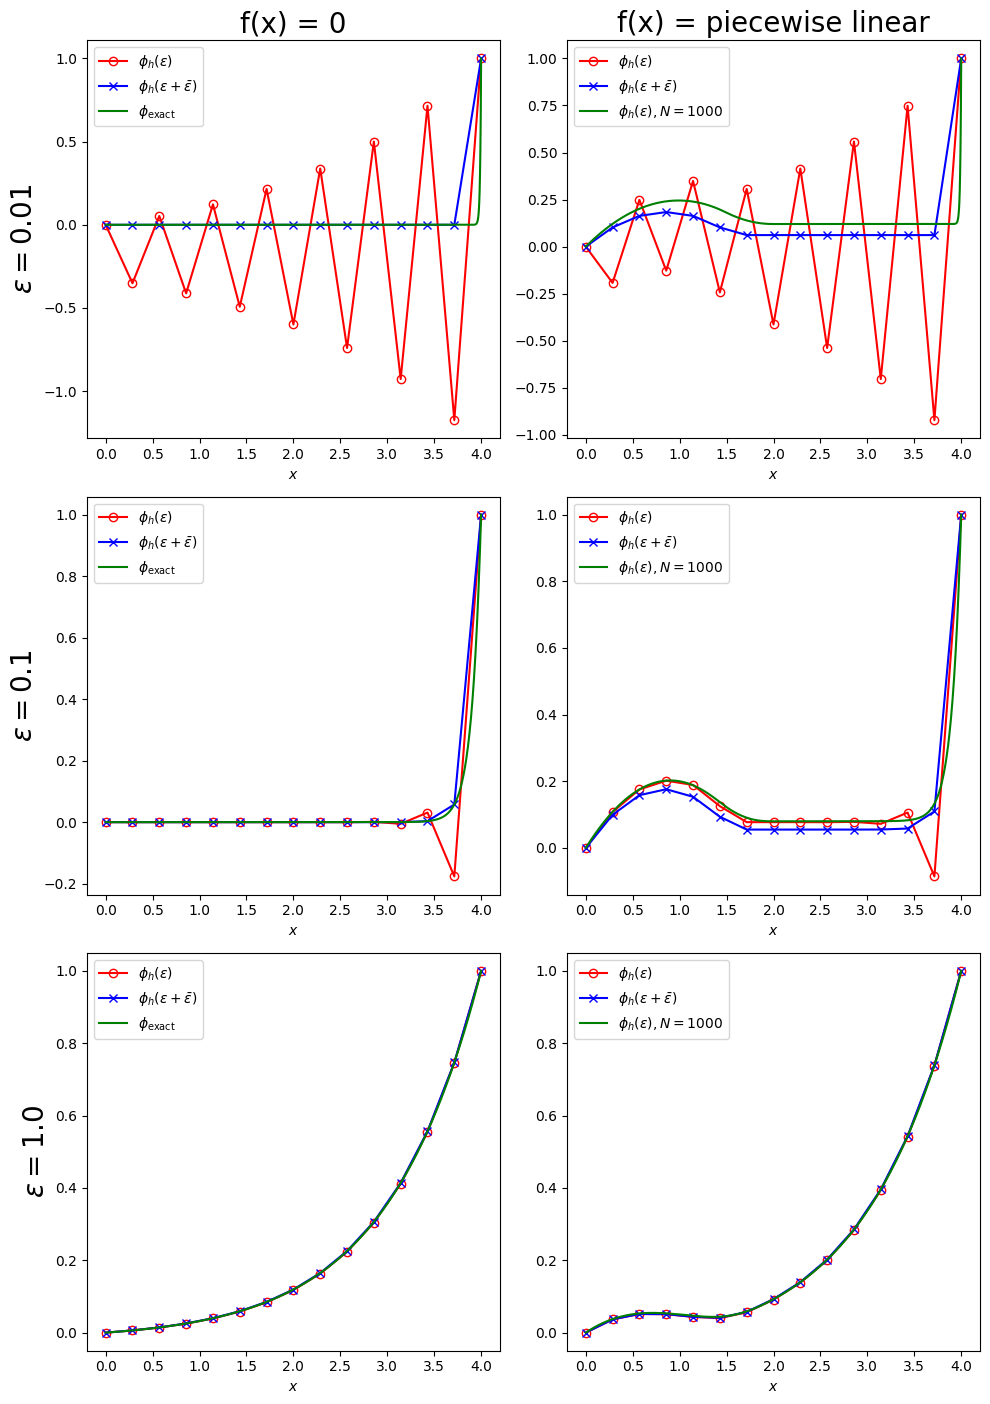

In [10]:
n_cells = 14
u = 1
L = 4
h = L / n_cells
epsilon = numpy.asarray([0.01, 0.1, 1.0])

Pe = u * h / (2 * epsilon) # mesh peclet number
epsilon_bar = epsilon * Pe * (numpy.cosh(Pe) / numpy.sinh(Pe)) # actually epsilon + epsilon_bar

phi_function = lambda x, e : (-1 + numpy.exp(u * x / e)) / (-1 + numpy.exp((L * u) / e)) # exact solution function
x_exact_plot = numpy.linspace(0, L, 1001)

fig, ax = plt.subplots(3, 2, figsize=(10, 14.14))
for i, ep in enumerate(epsilon):
    phi_exact = phi_function(x_exact_plot, epsilon[i])
    
    vertices, phi = do_calc(n_cells, L, u, epsilon[i], f0)
    ax[i, 0].plot(vertices, phi, 'red', marker = 'o', label=r'$\phi_h(\varepsilon)$', markerfacecolor='none')

    vertices, phi = do_calc(n_cells, L, u, epsilon_bar[i], f0)
    ax[i, 0].plot(vertices, phi, 'blue', marker = 'x', label=r'$\phi_h(\varepsilon + \bar{\varepsilon})$')

    ax[i, 0].plot(x_exact_plot, phi_exact, 'green', label=r'$\phi_{\mathrm{exact}}$')

    ax[i, 0].legend()
    ax[i, 0].set_xlabel(r'$x$')

    vertices, phi = do_calc(n_cells, L, u, epsilon[i], f1)
    ax[i, 1].plot(vertices, phi, 'red', marker = 'o', label=r'$\phi_h(\varepsilon)$', markerfacecolor='none')

    vertices, phi = do_calc(n_cells, L, u, epsilon_bar[i], f1)
    ax[i, 1].plot(vertices, phi, 'blue', marker = 'x', label=r'$\phi_h(\varepsilon + \bar{\varepsilon})$')

    vertices, phi = do_calc(1000, L, u, epsilon[i], f1) # 'exact solution'
    ax[i, 1].plot(vertices, phi, 'green', label=r'$\phi_h(\varepsilon), N = 1000$')

    ax[i, 1].legend()
    ax[i, 1].set_xlabel(r'$x$')

cols = [r"f(x) = 0", r"f(x) = piecewise linear"]
rows = [r"$\varepsilon = 0.01$", r"$\varepsilon = 0.1$", r"$\varepsilon = 1.0$", ]

for axx, col in zip(ax[0], cols):
    axx.set_title(col, size=20)

for axx, row in zip(ax[:,0], rows):
    axx.set_ylabel(row, rotation=90, size=20)

fig.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=34182dbb-ae12-40a8-aad2-b5663210f128' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>